In [1]:
#載入所需函示庫
from matplotlib import pyplot as plt
%matplotlib inline
# 設定圖形大小; DPI越大圖越大
plt.rcParams["figure.dpi"] = 80
import seaborn as sns
import pandas as pd
import numpy as np
import math
import statistics
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
import statsmodels.stats.multicomp as smm
import statsmodels.stats.outliers_influence as sso
import statsmodels
import warnings
warnings.filterwarnings("ignore")

def c_of_c_test(r, n, a):
    t_value = r * ((n-2)/(1 - r**2)) ** 0.5
    t_critical = stats.t.ppf(1 - a/2, n - 2)
    pval = stats.t.sf(np.abs(t_value), n - 2)*2
    print('r = ', r)
    print('t_critical = ', t_critical)
    print('t = ', t_value)
    print('p_value = ', pval)
    return t_value

def CI_simple_regression(df,x, y, x1, a):
    x_new = np.array([1, x1])
    X2 = sm.add_constant(x)
    olsmod = sm.OLS(y, X2)
    result_reg = olsmod.fit()
    #point prediction value
    y_head = np.dot(df.params, x_new)
    print("y_head = ", y_head)
    (t_minus, t_plus) = stats.t.interval(alpha = (1.0 - a), df = result_reg.df_resid )
    cov_mat1 = np.cov(y, x)
    x_bar = x.mean()
    core1 = (1 / result_reg.nobs + 
         (x1 - x_bar) ** 2 / (result_reg.nobs - 1) /    cov_mat1[1,1] ) ** 0.5
    lower_bound = y_head + t_minus * (result_reg.mse_resid ** 0.5) * core1
    upper_bound = y_head + t_plus * (result_reg.mse_resid ** 0.5) * core1
    half_interval = t_plus * (result_reg.mse_resid ** 0.5) * core1
    CI = np.array([lower_bound, upper_bound])
    print(f"{100*(1-a)}%% confidence interval for mean: [%0.4f, %0.4f]" % (lower_bound, upper_bound))
    print("    or %0.4f  +- %0.4f" % (y_head, half_interval))
    return CI

def PI_simple_regression(df,x, y, x1, a):
    x_new = np.array([1, x1])
    print("make prediction at new x = ", x1)
    X2 = sm.add_constant(x)
    olsmod = sm.OLS(y, X2)
    result_reg = olsmod.fit()
    y_head = np.dot(df.params, x_new)
    print("y_head = ", y_head)
    (t_minus, t_plus) = stats.t.interval(alpha = (1.0 - a), df = result_reg.df_resid )
    cov_mat1 = np.cov(y, x)
    x_bar = x.mean()
    core2 = (1 + 1 / result_reg.nobs + 
         (x1 - x_bar) ** 2 / (result_reg.nobs - 1) / cov_mat1[1,1] ) ** 0.5
    lower_bound = y_head + t_minus * (result_reg.mse_resid ** 0.5) * core2
    upper_bound = y_head + t_plus * (result_reg.mse_resid ** 0.5) * core2
    half_interval = t_plus * (result_reg.mse_resid ** 0.5) * core2
    PI = np.array([lower_bound, upper_bound])
    print(f"{100*(1-a)}%% prediction interval: [%0.4f, %0.4f]" % (lower_bound, upper_bound))
    print("    or %0.4f  +- %0.4f" % (y_head, half_interval))
    return PI

def Chi_Square_for_Normality(SD, N, a): 
    m = np.mean(SD)
    s = np.std(SD)   
    prob_bins = np.zeros((N + 1))
    z_bins = np.zeros((N + 1))
    z_bins[0] = -4
    z_bins[N] = 4
    for i in range(0, N+1):
        prob_bins[i] = i/N
    for j in range(1, N):
        z_bins[j] = m + stats.norm.isf(1 - prob_bins[j]) * s 
    counts, bins = np.histogram(SD, bins=z_bins)
    nobs = counts.sum()
    prob_e = np.zeros((N))
    for i in range(1, N+1):
        prob_e[i - 1] = prob_bins[i] - prob_bins[i - 1]
    freq_e = nobs * prob_e
    freq_o = counts
    if np.sum(freq_e < 5) > 0:
        print("Rule of five is not met. ")
        chi_pval = -99999 # Invalid
    else:
        chi_stat, pval = stats.chisquare(freq_o, freq_e) 
        chi_pval = stats.chi2.sf(chi_stat, N - 3)
        print("Chi-squared test: statistics = %0.4f, p-value = %0.4f" % (chi_stat, chi_pval))
    df = N - 3
    crit_value = stats.chi2.ppf(1 - a, df)
    print("Critical value = %0.4f (defree of freedom = %d)" % (crit_value, df))
    return chi_pval


def runsTest(l, l_median): 
    runs, n1, n2 = 1, 0, 0
    if(l[0]) >= l_median:
        n1 += 1   
    else:
        n2 += 1     
    # Checking for start of new run 
    for i in range(1,len(l)): 
        # no. of runs 
        if (l[i] >= l_median and l[i-1] < l_median) or (l[i] < l_median and l[i-1] >= l_median):
            runs += 1  
            # print(i, runs)
        # no. of positive values 
        if(l[i]) >= l_median: 
            n1 += 1   
        # no. of negative values 
        else: 
            n2 += 1   
    runs_exp = ((2*n1*n2)/(n1+n2)) + 1
    stan_dev = math.sqrt((2*n1*n2*(2*n1*n2-n1-n2))/(((n1+n2)**2)*(n1+n2-1))) 
    z = (runs-runs_exp)/stan_dev
    pval_z = stats.norm.sf(abs(z)) * 2
    print('runs = ', runs)
    print('n1 = ', n1)
    print('n2 = ', n2)
    print('runs_exp = ', runs_exp)
    print('stan_dev = ', stan_dev)
    print('z = ', z)
    print('pval_z = ', pval_z)
    return pval_z

def CI_PI_regression(xdata, yval, x1, a):
    print("make CI and PI prediction at mean of x = ", x1)
    X_data_T = xdata.T
    X_data2 = sm.add_constant(X_data_T)
    olsmod = sm.OLS(yval, X_data2)
    result_reg = olsmod.fit()
    y_head = np.dot(result_reg.params, x1)
    print("y_head = ", y_head)
    (t_minus, t_plus) = stats.t.interval(alpha = (1.0 - a), df = result_reg.df_resid )
    core1 = (result_reg.mse_resid * np.matmul(x1, np.linalg.solve(np.matmul(X_data2.T, X_data2), x1))) ** 0.5
    lower_bound = y_head +  t_minus * core1
    upper_bound = y_head +  t_plus * core1
    print("confidence interval of mean = [%0.4f, %0.4f] " % (lower_bound, upper_bound))
    core2 = (result_reg.mse_resid * (1 + np.matmul(x1, np.linalg.solve(np.matmul(X_data2.T, X_data2), x1)))) ** 0.5
    lower_bound2 = y_head +  t_minus * core2
    upper_bound2 = y_head +  t_plus * core2
    print("Prediction interval = [%0.4f, %0.4f] " % (lower_bound2, upper_bound2))
    CI_PI = np.array([lower_bound, upper_bound, lower_bound2, upper_bound2])
    return CI_PI

def Durbin_Watson_test(x):
    x_square_sum = np.vdot(x, x)
    print("x_square_sum = ", x_square_sum)
    size = x.size
    print("size = ", size)
    x_d = np.zeros((size))
    print("x_d = ", x_d)
    l_size = size - 1
    for i in range(l_size):
        x_d[i + 1] = x[i + 1] - x[i]
    print("x_d = ", x_d)
    d = np.vdot(x_d, x_d) / x_square_sum
    print("d = ", d)
    return(d)

def value_to_int(x):
    if type(x) == float or type(x) == int:
        return x
    if 'K' in x:
        if len(x) > 1:
            return int(float(x.replace('K', '')) * 1000)
        return 1000
    if 'M' in x:
        if len(x) > 1:
            return int(float(x.replace('M', '')) * 1000000)
        return 1000000
    if 'B' in x:
        return int(float(x.replace('B', '')) * 1000000000)
    if ' ' in x:
        return int(float(x.replace(' ','')))
    return int(x)



In [9]:
df = pd.read_excel('output.xlsx')
display(df)

,Unnamed: 0,Website,Trustworthiness,Avg_Daily_Visitors,Child_Safety,Avg_Daily_Pageviews,Privacy,Facebook_likes,Twitter_mentions,Google_pluses,LinkedIn_mentions,Pinterest_pins,StumbleUpon_views,Traffic_Rank,Location,Hosted_by,country
0,0,www.google.com.af,Excellent,NaN,Excellent,NaN,Excellent,9,1,37,7,-,7,954,United States,Google Inc.,Afghanistan
1,1,www.google.com,Excellent,515 007 350,Excellent,4 192 159 833,Excellent,94.2K,11.2K,11.7M,1.67K,10.8K,246K,1,United States,Google Inc.,Afghanistan
2,2,www.youtube.com,Excellent,506 457 282,Excellent,2 679 159 025,Excellent,13.5K,16.5K,19.3M,60K,47,329K,2,United States,Google Inc.,Afghanistan
3,3,www.facebook.com,Excellent,270 071 255,Good,1 082 985 733,Excellent,5.87M,64.4K,127K,6.23K,4.15K,23.1K,3,Ireland,Facebook,Afghanistan
4,4,www.yahoo.com,Excellent,99 572 035,Excellent,383 352 336,Excellent,17.2K,1.11K,798K,7.5K,433,68.9K,6,United States,Yahoo! Inc.,Afghanistan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3396,3396,www.propertybook.co.zw,Unknown,505,Unknown,1 009,Unknown,2,-,-,86,-,1,438 021,United States,"CloudFlare, Inc.",Zimbabwe
3397,3397,www.dailynews.co.zw,Unknown,11 902,Unknown,28 566,Unknown,-,27,42,5,-,-,85 166,Ireland,"Amazon.com, Inc.",Zimbabwe
3398,3398,www.newsdzezimbabwe.co.uk,Unknown,11 862,Unknown,51 010,Unknown,-,15,3,-,-,-,77 934,United States,Google Inc.,Zimbabwe
3399,3399,www.nehandaradio.com,Unknown,9 946,Unknown,19 894,Unknown,3,256,214,4,-,1,58 327,United States,"CloudFlare, Inc.",Zimbabwe


## 對Pageviews而言Google的 R-squared值最高，用它來做

<div style="background-color:#D9D9D9;"><font size="5">同時符合outliers & influential才刪, 10次</font></div>
<br> ### 最終結果為R-squared = 0.004

In [10]:
# #同時符合out+influ才刪
# fb = df[df["Google_pluses"].str.contains("-")==False]
# fb = fb[['Avg_Daily_Pageviews','Google_pluses','Website']]
# fb['Google_pluses'] = fb['Google_pluses'].apply(value_to_int)
# fb.dropna(inplace=True)
# fb.sort_values(by=['Google_pluses'], ascending = False, inplace=True)
# fb.reset_index(inplace = True, drop = True)
# fb['Avg_Daily_Pageviews'] = fb['Avg_Daily_Pageviews'].apply(value_to_int)
# #fb = fb[100:]
# display(fb)
# # draw plot
# _ = sns.regplot(x='Google_pluses', y= 'Avg_Daily_Pageviews', data = fb, color = 'b', ci = None)
# #plt.plot(x=fb['Google_pluses'],y=fb['Avg_Daily_Pageviews'].mean())
# plt.axhline(y=fb['Avg_Daily_Pageviews'].mean(), color='r', linestyle='-')
# plt.title('Scatter Plot for Google Pluses & Avg Daily Pageviews ')
# plt.xlabel('Google Pluses')
# plt.ylabel('Avg Daily Pageviews')
# plt.show()
# # Fit regression model 
# fb_result = smf.ols('Avg_Daily_Pageviews~ Google_pluses', data=fb).fit()
# # Inspect the results
# print(fb_result.summary())


# loop = 10
# for i in range(loop):
#     b1 = fb_result.params[1]
#     b0 = fb_result.params[0]
#     st1, data1, ss3 = sso.summary_table(fb_result, alpha=0.05)
#     SD = data1[:, 10]
#     mu = np.mean(SD)
#     sigma = np.std(SD)
#     fb_c = pd.DataFrame(SD,columns = ['SD'])
#     filter = (fb_c['SD'] < -2) | (fb_c['SD'] > 2)
#     #print("Outliers by SD = \n")
#     #print(fb_c['SD'].loc[filter])
#     out_index = fb_c['SD'].loc[filter].index
#     #out_index
#     fb_c = pd.DataFrame(SD,columns = ['SD'])

#     #print("\nInfluential Observations \n")
#     x_data = fb['Google_pluses'].values
#     y_data = fb['Avg_Daily_Pageviews'].values
#     cov_mat1 = np.cov(y_data, x_data)
#     x_data_bar = x_data.mean()
#     data_nobs = len(x_data)
#     h_val = 1 / data_nobs + (x_data - x_data_bar) ** 2 / (data_nobs - 1) / cov_mat1[1,1]
#     fb_h = pd.DataFrame(h_val,columns = ['hi'])
#     filter = (fb_h['hi'] > 6 / data_nobs )
#     #print("Influential Observations by hi = \n")
#     #print(fb_h['hi'].loc[filter])
#     influ_index = fb_h['hi'].loc[filter].index
#     #influ_index
#     #new fb
#     cross = list(set(influ_index).intersection(out_index))
# #     print(cross)
#     fb.drop(cross, axis=0, inplace=True)
# #     display(fb)
    
#     # draw plot
#     _ = sns.regplot(x='Google_pluses', y= 'Avg_Daily_Pageviews', data = fb, color = 'b', ci = None)
#     #plt.plot(x=fb['Google_pluses'],y=fb['Avg_Daily_Pageviews'].mean())
#     plt.axhline(y=fb['Avg_Daily_Pageviews'].mean(), color='r', linestyle='-')
#     plt.title('Scatter Plot for Google Pluses & Avg Daily Pageviews ')
#     plt.xlabel('Google Pluses')
#     plt.ylabel('Avg Daily Pageviews')
#     plt.show()
#     # Fit regression model 
#     fb_result = smf.ols('Avg_Daily_Pageviews~ Google_pluses', data=fb).fit()
#     # Inspect the results
#     print("try: ",i+1)
#     print(fb_result.summary())
#     fb.reset_index(inplace = True, drop = True)

# 純刪除十次outliers & influential 重疊部分
<br> ###最終結果為R-squared = 0.602

1917637.2331288343


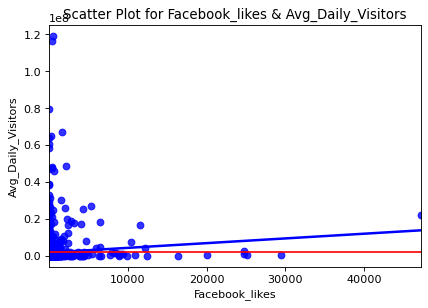


Avg_Daily_Visitors of Facebook_likes after 10 times of removing outliers:

                            OLS Regression Results                            
Dep. Variable:     Avg_Daily_Visitors   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     8.704
Date:                Tue, 17 May 2022   Prob (F-statistic):            0.00323
Time:                        21:27:21   Log-Likelihood:                -25315.
No. Observations:                1467   AIC:                         5.063e+04
Df Residuals:                    1465   BIC:                         5.064e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------

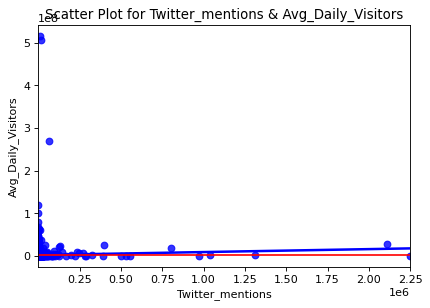


Avg_Daily_Visitors of Twitter_mentions after 10 times of removing outliers:

                            OLS Regression Results                            
Dep. Variable:     Avg_Daily_Visitors   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     2.321
Date:                Tue, 17 May 2022   Prob (F-statistic):              0.128
Time:                        21:27:22   Log-Likelihood:                -37803.
No. Observations:                2086   AIC:                         7.561e+04
Df Residuals:                    2084   BIC:                         7.562e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------

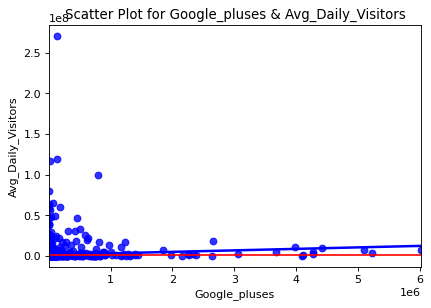


Avg_Daily_Visitors of Google_pluses after 10 times of removing outliers:

                            OLS Regression Results                            
Dep. Variable:     Avg_Daily_Visitors   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     16.83
Date:                Tue, 17 May 2022   Prob (F-statistic):           4.21e-05
Time:                        21:27:23   Log-Likelihood:                -48035.
No. Observations:                2777   AIC:                         9.607e+04
Df Residuals:                    2775   BIC:                         9.609e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------

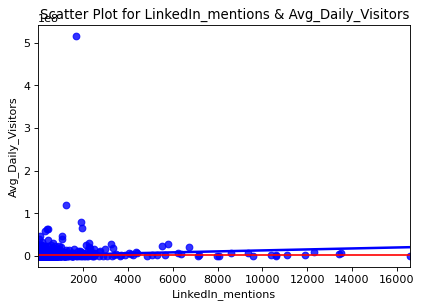


Avg_Daily_Visitors of LinkedIn_mentions after 10 times of removing outliers:

                            OLS Regression Results                            
Dep. Variable:     Avg_Daily_Visitors   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     21.36
Date:                Tue, 17 May 2022   Prob (F-statistic):           4.04e-06
Time:                        21:27:25   Log-Likelihood:                -36740.
No. Observations:                2068   AIC:                         7.348e+04
Df Residuals:                    2066   BIC:                         7.350e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------

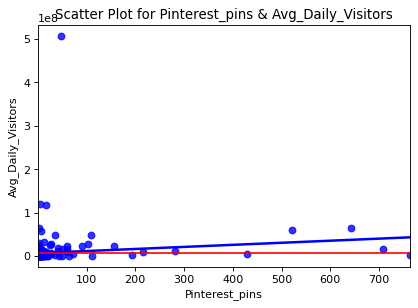


Avg_Daily_Visitors of Pinterest_pins after 10 times of removing outliers:

                            OLS Regression Results                            
Dep. Variable:     Avg_Daily_Visitors   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     4.030
Date:                Tue, 17 May 2022   Prob (F-statistic):             0.0458
Time:                        21:27:25   Log-Likelihood:                -4748.2
No. Observations:                 253   AIC:                             9500.
Df Residuals:                     251   BIC:                             9507.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------

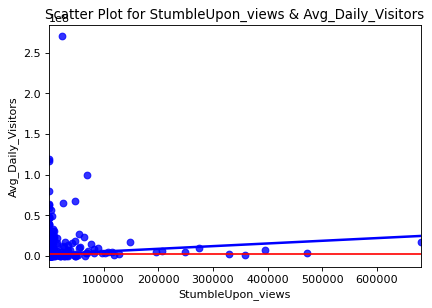


Avg_Daily_Visitors of StumbleUpon_views after 10 times of removing outliers:

                            OLS Regression Results                            
Dep. Variable:     Avg_Daily_Visitors   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     15.62
Date:                Tue, 17 May 2022   Prob (F-statistic):           8.07e-05
Time:                        21:27:26   Log-Likelihood:                -29468.
No. Observations:                1679   AIC:                         5.894e+04
Df Residuals:                    1677   BIC:                         5.895e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------

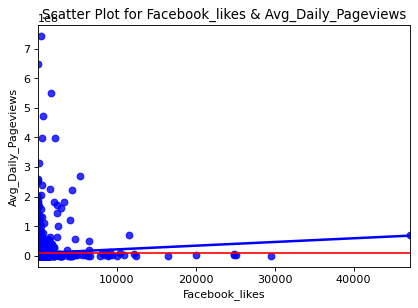


Avg_Daily_Pageviews of Facebook_likes after 10 times of removing outliers:

                             OLS Regression Results                            
Dep. Variable:     Avg_Daily_Pageviews   R-squared:                       0.004
Model:                             OLS   Adj. R-squared:                  0.003
Method:                  Least Squares   F-statistic:                     6.133
Date:                 Tue, 17 May 2022   Prob (F-statistic):             0.0134
Time:                         21:27:27   Log-Likelihood:                -27900.
No. Observations:                 1467   AIC:                         5.580e+04
Df Residuals:                     1465   BIC:                         5.581e+04
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

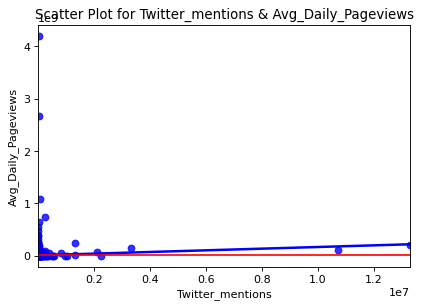


Avg_Daily_Pageviews of Twitter_mentions after 10 times of removing outliers:

                             OLS Regression Results                            
Dep. Variable:     Avg_Daily_Pageviews   R-squared:                       0.003
Model:                             OLS   Adj. R-squared:                  0.002
Method:                  Least Squares   F-statistic:                     5.815
Date:                 Tue, 17 May 2022   Prob (F-statistic):             0.0160
Time:                         21:27:28   Log-Likelihood:                -41815.
No. Observations:                 2091   AIC:                         8.363e+04
Df Residuals:                     2089   BIC:                         8.365e+04
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

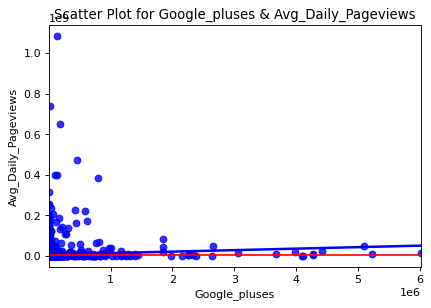


Avg_Daily_Pageviews of Google_pluses after 10 times of removing outliers:

                             OLS Regression Results                            
Dep. Variable:     Avg_Daily_Pageviews   R-squared:                       0.004
Model:                             OLS   Adj. R-squared:                  0.004
Method:                  Least Squares   F-statistic:                     12.21
Date:                 Tue, 17 May 2022   Prob (F-statistic):           0.000482
Time:                         21:27:30   Log-Likelihood:                -52386.
No. Observations:                 2778   AIC:                         1.048e+05
Df Residuals:                     2776   BIC:                         1.048e+05
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------

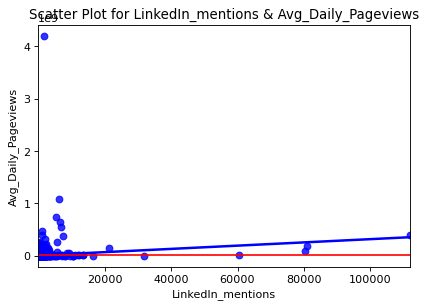


Avg_Daily_Pageviews of LinkedIn_mentions after 10 times of removing outliers:

                             OLS Regression Results                            
Dep. Variable:     Avg_Daily_Pageviews   R-squared:                       0.015
Model:                             OLS   Adj. R-squared:                  0.014
Method:                  Least Squares   F-statistic:                     30.79
Date:                 Tue, 17 May 2022   Prob (F-statistic):           3.24e-08
Time:                         21:27:31   Log-Likelihood:                -41279.
No. Observations:                 2079   AIC:                         8.256e+04
Df Residuals:                     2077   BIC:                         8.257e+04
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

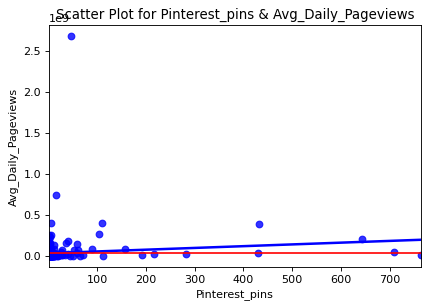


Avg_Daily_Pageviews of Pinterest_pins after 10 times of removing outliers:

                             OLS Regression Results                            
Dep. Variable:     Avg_Daily_Pageviews   R-squared:                       0.011
Model:                             OLS   Adj. R-squared:                  0.007
Method:                  Least Squares   F-statistic:                     2.789
Date:                 Tue, 17 May 2022   Prob (F-statistic):             0.0961
Time:                         21:27:31   Log-Likelihood:                -5170.2
No. Observations:                  253   AIC:                         1.034e+04
Df Residuals:                      251   BIC:                         1.035e+04
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

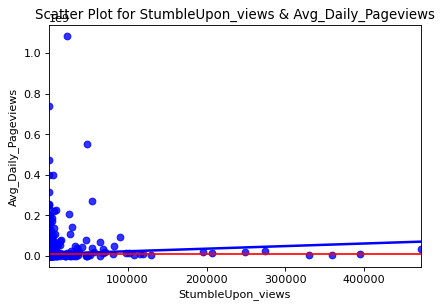


Avg_Daily_Pageviews of StumbleUpon_views after 10 times of removing outliers:

                             OLS Regression Results                            
Dep. Variable:     Avg_Daily_Pageviews   R-squared:                       0.004
Model:                             OLS   Adj. R-squared:                  0.004
Method:                  Least Squares   F-statistic:                     7.293
Date:                 Tue, 17 May 2022   Prob (F-statistic):            0.00699
Time:                         21:27:32   Log-Likelihood:                -31967.
No. Observations:                 1675   AIC:                         6.394e+04
Df Residuals:                     1673   BIC:                         6.395e+04
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

In [11]:
avg_dailys = ['Avg_Daily_Visitors', 'Avg_Daily_Pageviews']
media = ['Facebook_likes', 'Twitter_mentions', 'Google_pluses', 'LinkedIn_mentions', 'Pinterest_pins', 'StumbleUpon_views']


r_sqr = {}

for ad in avg_dailys:
    for md in media:
        #純刪掉outliers
        fb = df[df[md].str.contains("-")==False]
        fb = fb[[ad,md,'Website']]
        fb[md] = fb[md].apply(value_to_int)
        fb.dropna(inplace=True)
        fb.sort_values(by=[md], ascending = False, inplace=True)
        fb.reset_index(inplace = True, drop = True)
        fb[ad] = fb[ad].apply(value_to_int)
        #fb = fb[100:]
#         display(fb)

#         # draw plot
#         _ = sns.regplot(x=md, y=ad, data = fb, color = 'b', ci = None)
#         #plt.plot(x=fb['Google_pluses'],y=fb['Avg_Daily_Pageviews'].mean())
#         plt.axhline(y=fb[ad].mean(), color='r', linestyle='-')
#         plt.title('Scatter Plot for ' + md +' & ' + ad)
#         plt.xlabel(md)
#         plt.ylabel(ad)
#         plt.show()

        # Fit regression model 
        fb_result = smf.ols(ad+'~'+ md, data=fb).fit()
        # Inspect the results
#         print(fb_result.summary())


        loop = 10
        for i in range(loop):
        #     print("\n\n================================================================================================\n\n")
        #     print(f"The {i+1}th time removing outliers:\n")
            b1 = fb_result.params[1]
            b0 = fb_result.params[0]
            st1, data1, ss3 = sso.summary_table(fb_result, alpha=0.05)
            SD = data1[:, 10]
            mu = np.mean(SD)
            sigma = np.std(SD)
            fb_c = pd.DataFrame(SD,columns = ['SD'])
            filter = (fb_c['SD'] < -2) | (fb_c['SD'] > 2)
            #print("Outliers by SD = \n")
            #print(fb_c['SD'].loc[filter])
            outlier_index = list(fb_c['SD'].loc[filter].index)

            x_data = fb[md].values
            y_data = fb[ad].values
            cov_mat = np.cov(y_data, x_data)
            x_data_bar = x_data.mean()
            data_nobs = len(x_data)
            h_val = 1 / data_nobs + (x_data - x_data_bar) ** 2 / (data_nobs - 1) / cov_mat[1,1]
            df_hi = pd.DataFrame(h_val,columns = ['hi'])
            filter = (df_hi['hi'] > 6 / data_nobs )
            influs = df_hi['hi'].loc[filter]
            influ_index = list(influs.index)
            
            #out_index
            out_index = []
            for j in set(outlier_index).intersection(set(influ_index)):
                out_index.append(j)
            fb.drop(out_index, axis=0, inplace=True)
            # draw plot
            if i == loop - 1:
                _ = sns.regplot(x=md, y=ad, data = fb, color = 'b', ci = None)
                #plt.plot(x=fb['Google_pluses'],y=fb['Avg_Daily_Pageviews'].mean())
                plt.axhline(y=fb[ad].mean(), color='r', linestyle='-')
                plt.title('Scatter Plot for ' + md +' & ' + ad)
                print(fb[ad].mean())
                plt.xlabel(md)
                plt.ylabel(ad)
                plt.show()

            # Fit regression model 
            fb_result = smf.ols(ad+'~'+ md, data=fb).fit()

            # Inspect the results
            if i == loop - 1:
                print("")
                print(ad + " of " + md, end='')
                print(f" after {loop} times of removing outliers:\n")
                print(fb_result.summary())
                r_sqr[ad + " of " + md] = float("{:.2f}".format(fb_result.rsquared))
                
#                 print("\n\n\n", fb_result.rsquared, "\n\n\n")
            fb.reset_index(inplace = True, drop = True)
    

print("R Squareds:")
for item, amount in r_sqr.items():  # dct.iteritems() in Python 2
    print("{} {}".format(item, amount))
    
# print(r_sqr)


# 純刪除十次outliers

76124.30036188179


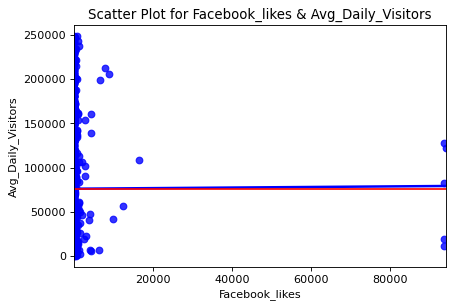


Avg_Daily_Visitors of Facebook_likes after 10 times of removing outliers:

                            OLS Regression Results                            
Dep. Variable:     Avg_Daily_Visitors   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                   0.01014
Date:                Tue, 17 May 2022   Prob (F-statistic):              0.920
Time:                        20:42:11   Log-Likelihood:                -10401.
No. Observations:                 829   AIC:                         2.081e+04
Df Residuals:                     827   BIC:                         2.082e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------

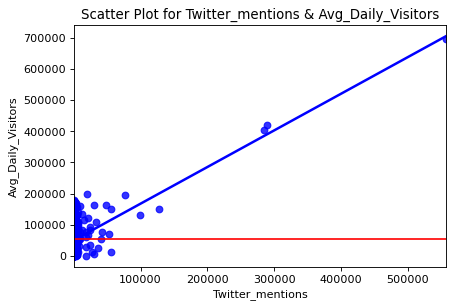


Avg_Daily_Visitors of Twitter_mentions after 10 times of removing outliers:

                            OLS Regression Results                            
Dep. Variable:     Avg_Daily_Visitors   R-squared:                       0.200
Model:                            OLS   Adj. R-squared:                  0.200
Method:                 Least Squares   F-statistic:                     293.3
Date:                Tue, 17 May 2022   Prob (F-statistic):           7.59e-59
Time:                        20:42:12   Log-Likelihood:                -14338.
No. Observations:                1172   AIC:                         2.868e+04
Df Residuals:                    1170   BIC:                         2.869e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------

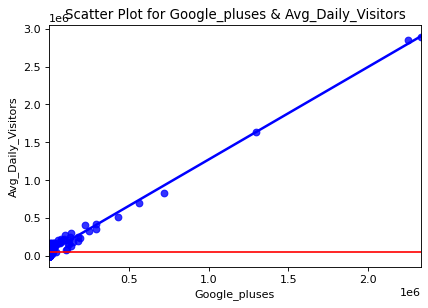


Avg_Daily_Visitors of Google_pluses after 10 times of removing outliers:

                            OLS Regression Results                            
Dep. Variable:     Avg_Daily_Visitors   R-squared:                       0.862
Model:                            OLS   Adj. R-squared:                  0.862
Method:                 Least Squares   F-statistic:                     9833.
Date:                Tue, 17 May 2022   Prob (F-statistic):               0.00
Time:                        20:42:13   Log-Likelihood:                -19074.
No. Observations:                1570   AIC:                         3.815e+04
Df Residuals:                    1568   BIC:                         3.816e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------

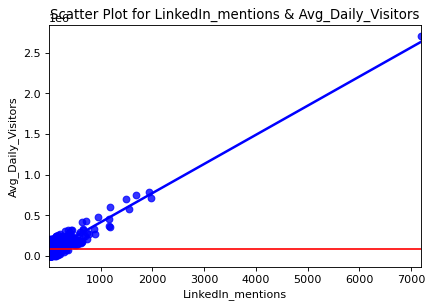


Avg_Daily_Visitors of LinkedIn_mentions after 10 times of removing outliers:

                            OLS Regression Results                            
Dep. Variable:     Avg_Daily_Visitors   R-squared:                       0.735
Model:                            OLS   Adj. R-squared:                  0.735
Method:                 Least Squares   F-statistic:                     3179.
Date:                Tue, 17 May 2022   Prob (F-statistic):               0.00
Time:                        20:42:15   Log-Likelihood:                -14215.
No. Observations:                1146   AIC:                         2.843e+04
Df Residuals:                    1144   BIC:                         2.844e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------

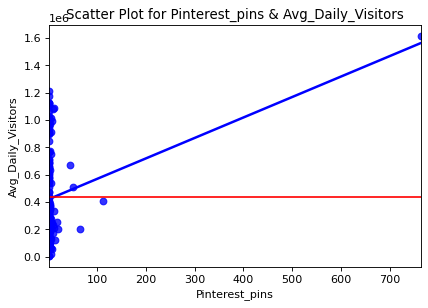


Avg_Daily_Visitors of Pinterest_pins after 10 times of removing outliers:

                            OLS Regression Results                            
Dep. Variable:     Avg_Daily_Visitors   R-squared:                       0.082
Model:                            OLS   Adj. R-squared:                  0.075
Method:                 Least Squares   F-statistic:                     12.43
Date:                Tue, 17 May 2022   Prob (F-statistic):           0.000573
Time:                        20:42:15   Log-Likelihood:                -1989.3
No. Observations:                 141   AIC:                             3983.
Df Residuals:                     139   BIC:                             3989.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------

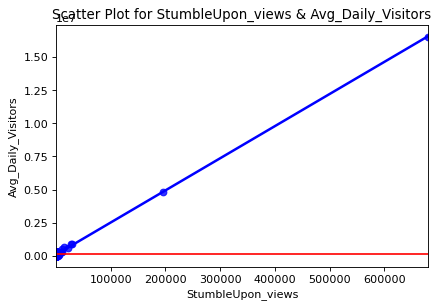


Avg_Daily_Visitors of StumbleUpon_views after 10 times of removing outliers:

                            OLS Regression Results                            
Dep. Variable:     Avg_Daily_Visitors   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                 4.398e+04
Date:                Tue, 17 May 2022   Prob (F-statistic):               0.00
Time:                        20:42:16   Log-Likelihood:                -11902.
No. Observations:                 935   AIC:                         2.381e+04
Df Residuals:                     933   BIC:                         2.382e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------

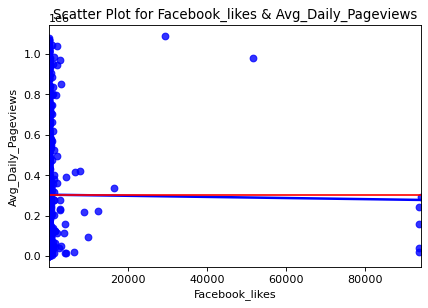


Avg_Daily_Pageviews of Facebook_likes after 10 times of removing outliers:

                             OLS Regression Results                            
Dep. Variable:     Avg_Daily_Pageviews   R-squared:                       0.000
Model:                             OLS   Adj. R-squared:                 -0.001
Method:                  Least Squares   F-statistic:                   0.04088
Date:                 Tue, 17 May 2022   Prob (F-statistic):              0.840
Time:                         20:42:17   Log-Likelihood:                -11864.
No. Observations:                  846   AIC:                         2.373e+04
Df Residuals:                      844   BIC:                         2.374e+04
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

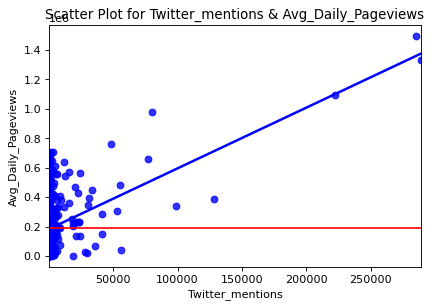


Avg_Daily_Pageviews of Twitter_mentions after 10 times of removing outliers:

                             OLS Regression Results                            
Dep. Variable:     Avg_Daily_Pageviews   R-squared:                       0.100
Model:                             OLS   Adj. R-squared:                  0.099
Method:                  Least Squares   F-statistic:                     129.5
Date:                 Tue, 17 May 2022   Prob (F-statistic):           1.53e-28
Time:                         20:42:18   Log-Likelihood:                -15937.
No. Observations:                 1174   AIC:                         3.188e+04
Df Residuals:                     1172   BIC:                         3.189e+04
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

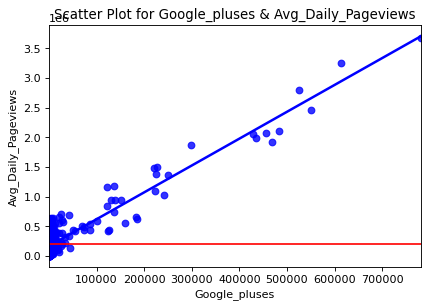


Avg_Daily_Pageviews of Google_pluses after 10 times of removing outliers:

                             OLS Regression Results                            
Dep. Variable:     Avg_Daily_Pageviews   R-squared:                       0.602
Model:                             OLS   Adj. R-squared:                  0.602
Method:                  Least Squares   F-statistic:                     2319.
Date:                 Tue, 17 May 2022   Prob (F-statistic):          6.52e-309
Time:                         20:42:19   Log-Likelihood:                -20634.
No. Observations:                 1533   AIC:                         4.127e+04
Df Residuals:                     1531   BIC:                         4.128e+04
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------

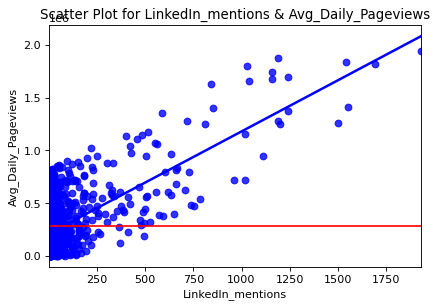


Avg_Daily_Pageviews of LinkedIn_mentions after 10 times of removing outliers:

                             OLS Regression Results                            
Dep. Variable:     Avg_Daily_Pageviews   R-squared:                       0.401
Model:                             OLS   Adj. R-squared:                  0.400
Method:                  Least Squares   F-statistic:                     761.5
Date:                 Tue, 17 May 2022   Prob (F-statistic):          8.89e-129
Time:                         20:42:20   Log-Likelihood:                -15721.
No. Observations:                 1141   AIC:                         3.145e+04
Df Residuals:                     1139   BIC:                         3.146e+04
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

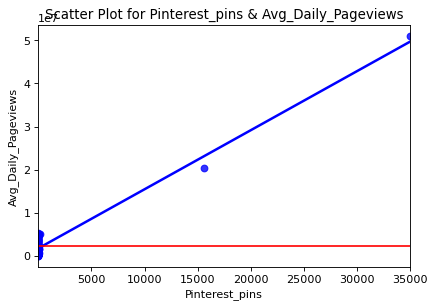


Avg_Daily_Pageviews of Pinterest_pins after 10 times of removing outliers:

                             OLS Regression Results                            
Dep. Variable:     Avg_Daily_Pageviews   R-squared:                       0.883
Model:                             OLS   Adj. R-squared:                  0.883
Method:                  Least Squares   F-statistic:                     1098.
Date:                 Tue, 17 May 2022   Prob (F-statistic):           1.59e-69
Time:                         20:42:21   Log-Likelihood:                -2305.1
No. Observations:                  147   AIC:                             4614.
Df Residuals:                      145   BIC:                             4620.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

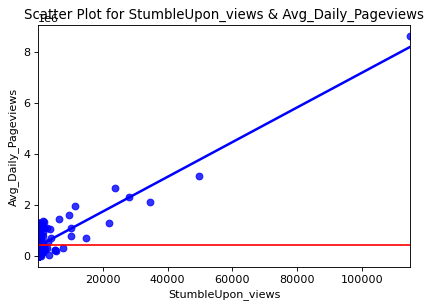


Avg_Daily_Pageviews of StumbleUpon_views after 10 times of removing outliers:

                             OLS Regression Results                            
Dep. Variable:     Avg_Daily_Pageviews   R-squared:                       0.429
Model:                             OLS   Adj. R-squared:                  0.428
Method:                  Least Squares   F-statistic:                     706.6
Date:                 Tue, 17 May 2022   Prob (F-statistic):          1.39e-116
Time:                         20:42:22   Log-Likelihood:                -13392.
No. Observations:                  943   AIC:                         2.679e+04
Df Residuals:                      941   BIC:                         2.680e+04
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

In [11]:
avg_dailys = ['Avg_Daily_Visitors', 'Avg_Daily_Pageviews']
media = ['Facebook_likes', 'Twitter_mentions', 'Google_pluses', 'LinkedIn_mentions', 'Pinterest_pins', 'StumbleUpon_views']


r_sqr = {}

for ad in avg_dailys:
    for md in media:

        #純刪掉outliers
        fb = df[df[md].str.contains("-")==False]
        fb = fb[[ad,md,'Website']]
        fb[md] = fb[md].apply(value_to_int)
        fb.dropna(inplace=True)
        fb.sort_values(by=[md], ascending = False, inplace=True)
        fb.reset_index(inplace = True, drop = True)
        fb[ad] = fb[ad].apply(value_to_int)
        #fb = fb[100:]
#         display(fb)
#         # draw plot
#         _ = sns.regplot(x=md, y=ad, data = fb, color = 'b', ci = None)
#         #plt.plot(x=fb['Google_pluses'],y=fb['Avg_Daily_Pageviews'].mean())
#         plt.axhline(y=fb[ad].mean(), color='r', linestyle='-')
#         plt.title('Scatter Plot for ' + md +' & ' + ad)
#         plt.xlabel(md)
#         plt.ylabel(ad)
#         plt.show()

        # Fit regression model 
        fb_result = smf.ols(ad+'~'+ md, data=fb).fit()
        # Inspect the results
#         print(fb_result.summary())


        loop = 10
        for i in range(loop):
        #     print("\n\n================================================================================================\n\n")
        #     print(f"The {i+1}th time removing outliers:\n")
            b1 = fb_result.params[1]
            b0 = fb_result.params[0]
            st1, data1, ss3 = sso.summary_table(fb_result, alpha=0.05)
            SD = data1[:, 10]
            mu = np.mean(SD)
            sigma = np.std(SD)
            fb_c = pd.DataFrame(SD,columns = ['SD'])
            filter = (fb_c['SD'] < -2) | (fb_c['SD'] > 2)
            #print("Outliers by SD = \n")
            #print(fb_c['SD'].loc[filter])
            out_index = fb_c['SD'].loc[filter].index

            #out_index
            out_index = list(out_index)
        #     print("removed indices:")
        #     print(out_index)
            fb.drop(out_index, axis=0, inplace=True)
        #     display(fb)

            # draw plot
            if i == loop - 1:
                _ = sns.regplot(x=md, y=ad, data = fb, color = 'b', ci = None)
                #plt.plot(x=fb['Google_pluses'],y=fb['Avg_Daily_Pageviews'].mean())
                plt.axhline(y=fb[ad].mean(), color='r', linestyle='-')
                plt.title('Scatter Plot for ' + md +' & ' + ad)
                print(fb[ad].mean())
                plt.xlabel(md)
                plt.ylabel(ad)
                plt.show()

            # Fit regression model 
            fb_result = smf.ols(ad+'~'+ md, data=fb).fit()

            # Inspect the results
            if i == loop - 1:
                print("")
                print(ad + " of " + md, end='')
                print(f" after {loop} times of removing outliers:\n")
                print(fb_result.summary())
                r_sqr[ad + " of " + md] = float("{:.2f}".format(fb_result.rsquared))
                
                
#                 print("\n\n\n", fb_result.rsquared, "\n\n\n")
            fb.reset_index(inplace = True, drop = True)
    

print("R Squareds:")
for item, amount in r_sqr.items():  # dct.iteritems() in Python 2
    print("{} {}".format(item, amount))
    
# print(r_sqr)


<div style="background-color:#D9D9D9;"><font size="5"> Pageviews取log＋刪除10次outliers</font></div><br>
### 最終結果為R-squared = 0.014

In [6]:
# #純刪掉outliers + log y
# fb = df[df["Google_pluses"].str.contains("-")==False]
# fb = fb[['Avg_Daily_Pageviews','Google_pluses','Website']]
# fb['Google_pluses'] = fb['Google_pluses'].apply(value_to_int)
# fb.dropna(inplace=True)
# fb.sort_values(by=['Google_pluses'], ascending = False, inplace=True)
# fb.reset_index(inplace = True, drop = True)
# fb['Avg_Daily_Pageviews'] = fb['Avg_Daily_Pageviews'].apply(value_to_int)
# fb['Avg_Daily_Pageviews'] = np.log(fb['Avg_Daily_Pageviews'])
# #fb = fb[100:]
# display(fb)
# # draw plot
# _ = sns.regplot(x='Google_pluses', y= 'Avg_Daily_Pageviews', data = fb, color = 'b', ci = None)
# #plt.plot(x=fb['Google_pluses'],y=fb['Avg_Daily_Pageviews'].mean())
# plt.axhline(y=fb['Avg_Daily_Pageviews'].mean(), color='r', linestyle='-')
# plt.title('Scatter Plot for Google Pluses & Avg Daily Pageviews ')
# plt.xlabel('Google Pluses')
# plt.ylabel('Avg Daily Pageviews')
# plt.show()
# # Fit regression model 
# fb_result = smf.ols('Avg_Daily_Pageviews~ Google_pluses', data=fb).fit()
# # Inspect the results
# print(fb_result.summary())
# for i in range(10):
#     b1 = fb_result.params[1]
#     b0 = fb_result.params[0]
#     st1, data1, ss3 = sso.summary_table(fb_result, alpha=0.05)
#     SD = data1[:, 10]
#     mu = np.mean(SD)
#     sigma = np.std(SD)
#     fb_c = pd.DataFrame(SD,columns = ['SD'])
#     filter = (fb_c['SD'] < -2) | (fb_c['SD'] > 2)
#     #print("Outliers by SD = \n")
#     #print(fb_c['SD'].loc[filter])
#     out_index = fb_c['SD'].loc[filter].index
#     #out_index
#     out_index = list(out_index)
#     print(out_index)
#     fb.drop(out_index, axis=0, inplace=True)
#     display(fb)
#     # draw plot
#     _ = sns.regplot(x='Google_pluses', y= 'Avg_Daily_Pageviews', data = fb, color = 'b', ci = None)
#     #plt.plot(x=fb['Google_pluses'],y=fb['Avg_Daily_Pageviews'].mean())
#     plt.axhline(y=fb['Avg_Daily_Pageviews'].mean(), color='r', linestyle='-')
#     plt.title('Scatter Plot for Google Pluses & Avg Daily Pageviews ')
#     print(fb['Avg_Daily_Pageviews'].mean())
#     plt.xlabel('Google Pluses')
#     plt.ylabel('Avg Daily Pageviews')
#     plt.show()
#     # Fit regression model 
#     fb_result = smf.ols('Avg_Daily_Pageviews~ Google_pluses', data=fb).fit()
#     # Inspect the results
#     print("try: ",i+1)
#     print(fb_result.summary())
#     fb.reset_index(inplace = True, drop = True)